# FloodWatch Model Metrics and Parameters

This notebook analyzes the trained RandomForest model from `FloodWatch/training/enhanced_train.py`.

It will:
- Summarize core and imbalanced classification metrics.
- Visualize the confusion matrix, ROC, and Precision-Recall curves.
- Show feature importances.
- List the key hyperparameters of the trained model.

In [2]:
# Imports
import os
import pickle
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    roc_curve, precision_recall_curve
 )

# Paths (derived from this notebook's location)
script_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
project_root = os.path.dirname(script_dir)
data_path = os.path.join(project_root, 'data', 'enhanced_training_data.csv')
model_path = os.path.join(project_root, 'training','model.pickle')
metrics_csv_path = os.path.join(project_root, 'data', 'model_metrics.csv')
feat_imp_path = os.path.join(project_root, 'data', 'feature_importance.csv')

print('Project root:', project_root)
print('Data path:', data_path)
print('Model path:', model_path)

Project root: d:\TEMPERORY\RESEARCH\FloodML-master\FloodWatch
Data path: d:\TEMPERORY\RESEARCH\FloodML-master\FloodWatch\data\enhanced_training_data.csv
Model path: d:\TEMPERORY\RESEARCH\FloodML-master\FloodWatch\training\model.pickle


## Load Data and Model
We load the same dataset used in training and recreate the stratified split (`test_size=0.3`, `random_state=42`) to reproduce the test set used in `enhanced_train.py`. Then we load the saved model.

In [3]:
# Load data
df = pd.read_csv(data_path)
X = df.drop('flood_class', axis=1)
y = df['flood_class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Load model
with open(model_path, 'rb') as f:
    model = pickle.load(f)

X_test.shape, y_test.shape, type(model).__name__

((136, 11), (136,), 'RandomForestClassifier')

## How the Training Data Was Constructed (from [training/enhanced_scraper.py](cci:7://file:///d:/TEMPERORY/RESEARCH/FloodML-master/FloodWatch/training/enhanced_scraper.py:0:0-0:0))

The dataset `data/enhanced_training_data.csv` is created by combining historical weather signals with reservoir status for cities, and labeling rows using real flood events with a fallback heuristic.

- Data sources and features:
  - Weather (Open-Meteo Archive, last 15 days window for each date/city):
    - temp_avg, temp_max, wind_speed, cloud_cover, precipitation, humidity
    - precip_cover = % of days with precipitation in the 15-day window
  - Reservoirs (from `data/aggregated_reservoir_data.csv`, per city-date with ±7-day fallback):
    - avg_reservoir_fill, max_reservoir_fill, reservoir_risk_score, reservoirs_above_danger

- Labeling:
  - Real flood events are loaded from `data/flood_events_clean.csv` when available and used to create positive samples (label = 1) on/near those event dates.
  - Additional samples are generated per city on random dates (2019–2024).
  - For these random dates, a heuristic labels the sample as 1 if the date is within 7 days of a known flood event in the same city; otherwise 0.

- Output schema:
  - Columns: [`temp_avg`, `temp_max`, `wind_speed`, `cloud_cover`, `precipitation`, `humidity`, `precip_cover`, `avg_reservoir_fill`, `max_reservoir_fill`, `reservoir_risk_score`, `reservoirs_above_danger`, `flood_class`]
  - `flood_class` is the binary target (0 = no flood, 1 = flood).

Notes:
- Missing or unavailable weather/reservoir data for a city-date is handled defensively; rows with all-zero features are skipped during construction.
- The training script ([training/enhanced_train.py](cci:7://file:///d:/TEMPERORY/RESEARCH/FloodML-master/FloodWatch/training/enhanced_train.py:0:0-0:0)) later stratifies the split and optimizes a class-balanced RandomForest using PR-AUC, which is more informative for imbalanced flood detection.

## Compute Metrics
We compute the core classification metrics and metrics tailored for class imbalance.

In [4]:
# Predictions and probabilities
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Core metrics
metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred, zero_division=0),
    'recall': recall_score(y_test, y_pred, zero_division=0),
    'f1_score': f1_score(y_test, y_pred, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_proba),
    'pr_auc': average_precision_score(y_test, y_proba),
}

# Confusion matrix and derived metrics
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
balanced_accuracy = (specificity + sensitivity) / 2

metrics.update({
    'specificity': specificity,
    'sensitivity': sensitivity,
    'balanced_accuracy': balanced_accuracy,
})

metrics_df = pd.DataFrame([metrics]).round(4)
metrics_df

,accuracy,precision,recall,f1_score,roc_auc,pr_auc,specificity,sensitivity,balanced_accuracy
0,0.5809,0.3421,0.2889,0.3133,0.6523,0.4226,0.7253,0.2889,0.5071


### Metric Notes
- Accuracy: Overall correct predictions.
- Precision: How many predicted floods are actual floods.
- Recall (Sensitivity): How many actual floods we detect.
- F1: Harmonic mean of Precision and Recall.
- Specificity: True Negative Rate.
- Balanced Accuracy: Average of Sensitivity and Specificity.
- ROC-AUC: Discrimination across thresholds (class-imbalance agnostic).
- PR-AUC: Precision-Recall area (preferred with imbalanced flood events).

## Confusion Matrix
Visualization of TN, FP, FN, TP on the test set.

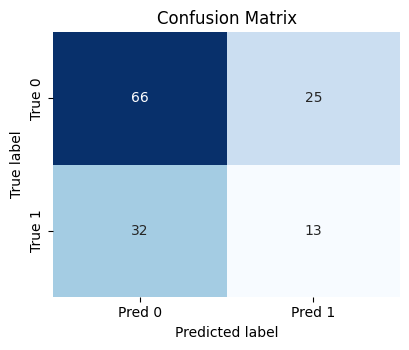

In [5]:
plt.figure(figsize=(4.2, 3.6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred 0','Pred 1'], yticklabels=['True 0','True 1'])
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## ROC and Precision-Recall Curves
These curves show performance across thresholds. PR curve is particularly informative for class imbalance.

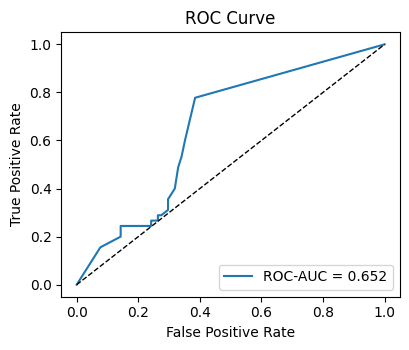

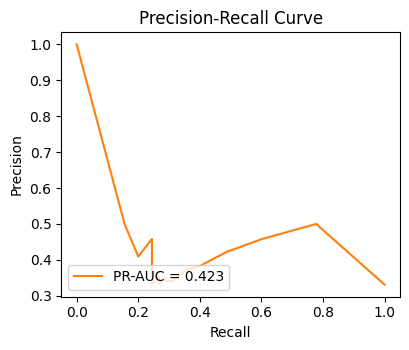

In [6]:
# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(4.2, 3.6))
plt.plot(fpr, tpr, label=f'ROC-AUC = {metrics["roc_auc"]:.3f}')
plt.plot([0,1],[0,1],'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Precision-Recall
prec, rec, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(4.2, 3.6))
plt.plot(rec, prec, label=f'PR-AUC = {metrics["pr_auc"]:.3f}', color='C1')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

## Feature Importance
We load saved importances and plot the top features.

C:\Users\karan\AppData\Local\Temp\ipykernel_7588\1893517235.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_feats, x='importance', y='feature', palette='viridis')


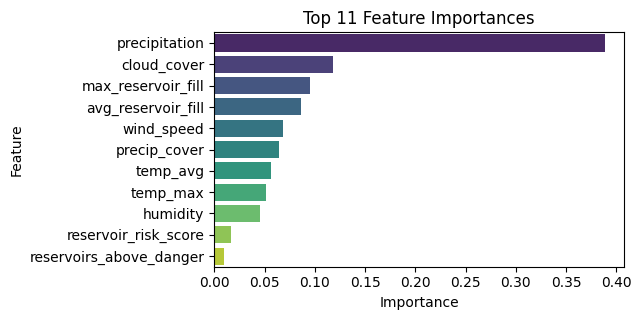

,feature,importance
0,precipitation,0.388159
1,cloud_cover,0.118182
2,max_reservoir_fill,0.095163
3,avg_reservoir_fill,0.086058
4,wind_speed,0.068717
5,precip_cover,0.063970
6,temp_avg,0.056412
7,temp_max,0.051566
8,humidity,0.045389
9,reservoir_risk_score,0.016273


In [7]:
feat_df = pd.read_csv(feat_imp_path)
top_n = 20
top_feats = feat_df.sort_values('importance', ascending=False).head(top_n)
plt.figure(figsize=(6.5, max(3.0, 0.3*len(top_feats))))
sns.barplot(data=top_feats, x='importance', y='feature', palette='viridis')
plt.title(f'Top {len(top_feats)} Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
top_feats

## Trained Model Hyperparameters
The model was tuned with RandomizedSearchCV optimizing PR-AUC and used `class_weight='balanced'`.
Below are the key hyperparameters of the saved estimator.

In [8]:
# Extract relevant RandomForest hyperparameters for readability
params = model.get_params() if hasattr(model, 'get_params') else {}
keys_of_interest = [
    'n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf',
    'criterion', 'max_features', 'class_weight', 'random_state'
]
readable_params = {k: params.get(k, None) for k in keys_of_interest}
pd.Series(readable_params)


n_estimators          150
max_depth              20
min_samples_split       2
min_samples_leaf        1
criterion            gini
max_features         sqrt
class_weight         None
random_state           42
dtype: object

### Notes on Interpretation
- Higher PR-AUC indicates better performance on detecting the positive (flood) class across thresholds.
- Evaluate trade-offs between Precision and Recall based on operational needs.
- Feature importances help identify key drivers (e.g., precipitation, reservoir fill levels).